# Exploring generations

In [6]:
# improts
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import re
from pathlib import Path
from glob import glob
import pickle
import shutil
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole, MolsToGridImage
import py3Dmol
import pandas as pd


# For highlight colors
from matplotlib.colors import ColorConverter

from ipywidgets import interact,fixed,IntSlider
                        
from ase.db import connect
from ase.io import read
from ase.visualize import view


module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:

    sys.path.append(module_path)
    
# Custom functions 
from my_utils.analysis import draw_generation,conf_viewer, conf_viewer_ga, natural_keys, atoi, sort_ga

#IPythonConsole.drawOptions.addAtomIndices = True
IPythonConsole.molSize = 500,500
IPythonConsole.drawOptions.addAtomIndices = True

font = {'weight' : 'bold',
        'size'   : 18}

plt.rc('font', **font)


# The original structure as reference:  

In [7]:
#Mo_hipt_path = '/home/magstr/Documents/nitrogenase/schrock/reference_structures/mo.xyz'
#draw_generation(Mo_hipt_path)

## PATHS: 

In [9]:
# Initilized path variables0
templates = Path('../templates/')

# Path to folder with GA.pkl files
generation_path = Path('~').expanduser()/"generation_data/prod_new30_small_0"
# What GA to look at 
gen  = 'GA50.pkl'

# How many molecules in the pop to look at 
size = 1

In [10]:
with open(generation_path/gen, "rb") as f:
    gen = pickle.load(f)

In [11]:
# Extract stuff from the generation

mols = []
list_idx = []
cut_idx = []
score = []
pre_mols = []
pre_mol_idx = []
struct=[]
struct2=[]

children_mols = []
children_idx = []
children_cut_idx = []
    
for elem in gen.molecules:
    mols.append(elem.rdkit_mol)    
    list_idx.append(elem.idx)
    score.append(round(elem.score,3))
    cut_idx.append([elem.cut_idx])
    struct.append(elem.structure)
    struct2.append(elem.structure2)
    
for elem in gen.new_molecules:
    children_mols.append(elem.rdkit_mol)    
    children_idx.append(elem.idx)
    pre_mols.append(elem.original_mol)
    children_cut_idx.append([elem.cut_idx])
    

pop = {}
keys = range(len(struct))
for i in keys:
    pop[i] = (list_idx[i],score[i],struct[i])
pop2 = {}
keys = range(len(struct2))
for i in keys:
    pop2[i] = (list_idx[i],score[i],struct2[i])

In [12]:
img  = Draw.MolsToGridImage(mols,molsPerRow=3,maxMols=25,legends=[f'Score:  {round(score,3)}' for x, score in zip(list_idx,score)], subImgSize=(400,200), highlightAtomLists=cut_idx, returnPNG=False)

/home/magstr/miniconda3/envs/mols_test/lib/python3.7/site-packages/rdkit/Chem/Draw/IPythonConsole.py:243: UserWarning: Truncating the list of molecules to be displayed to 25. Change the maxMols value to display more.
  % (maxMols))


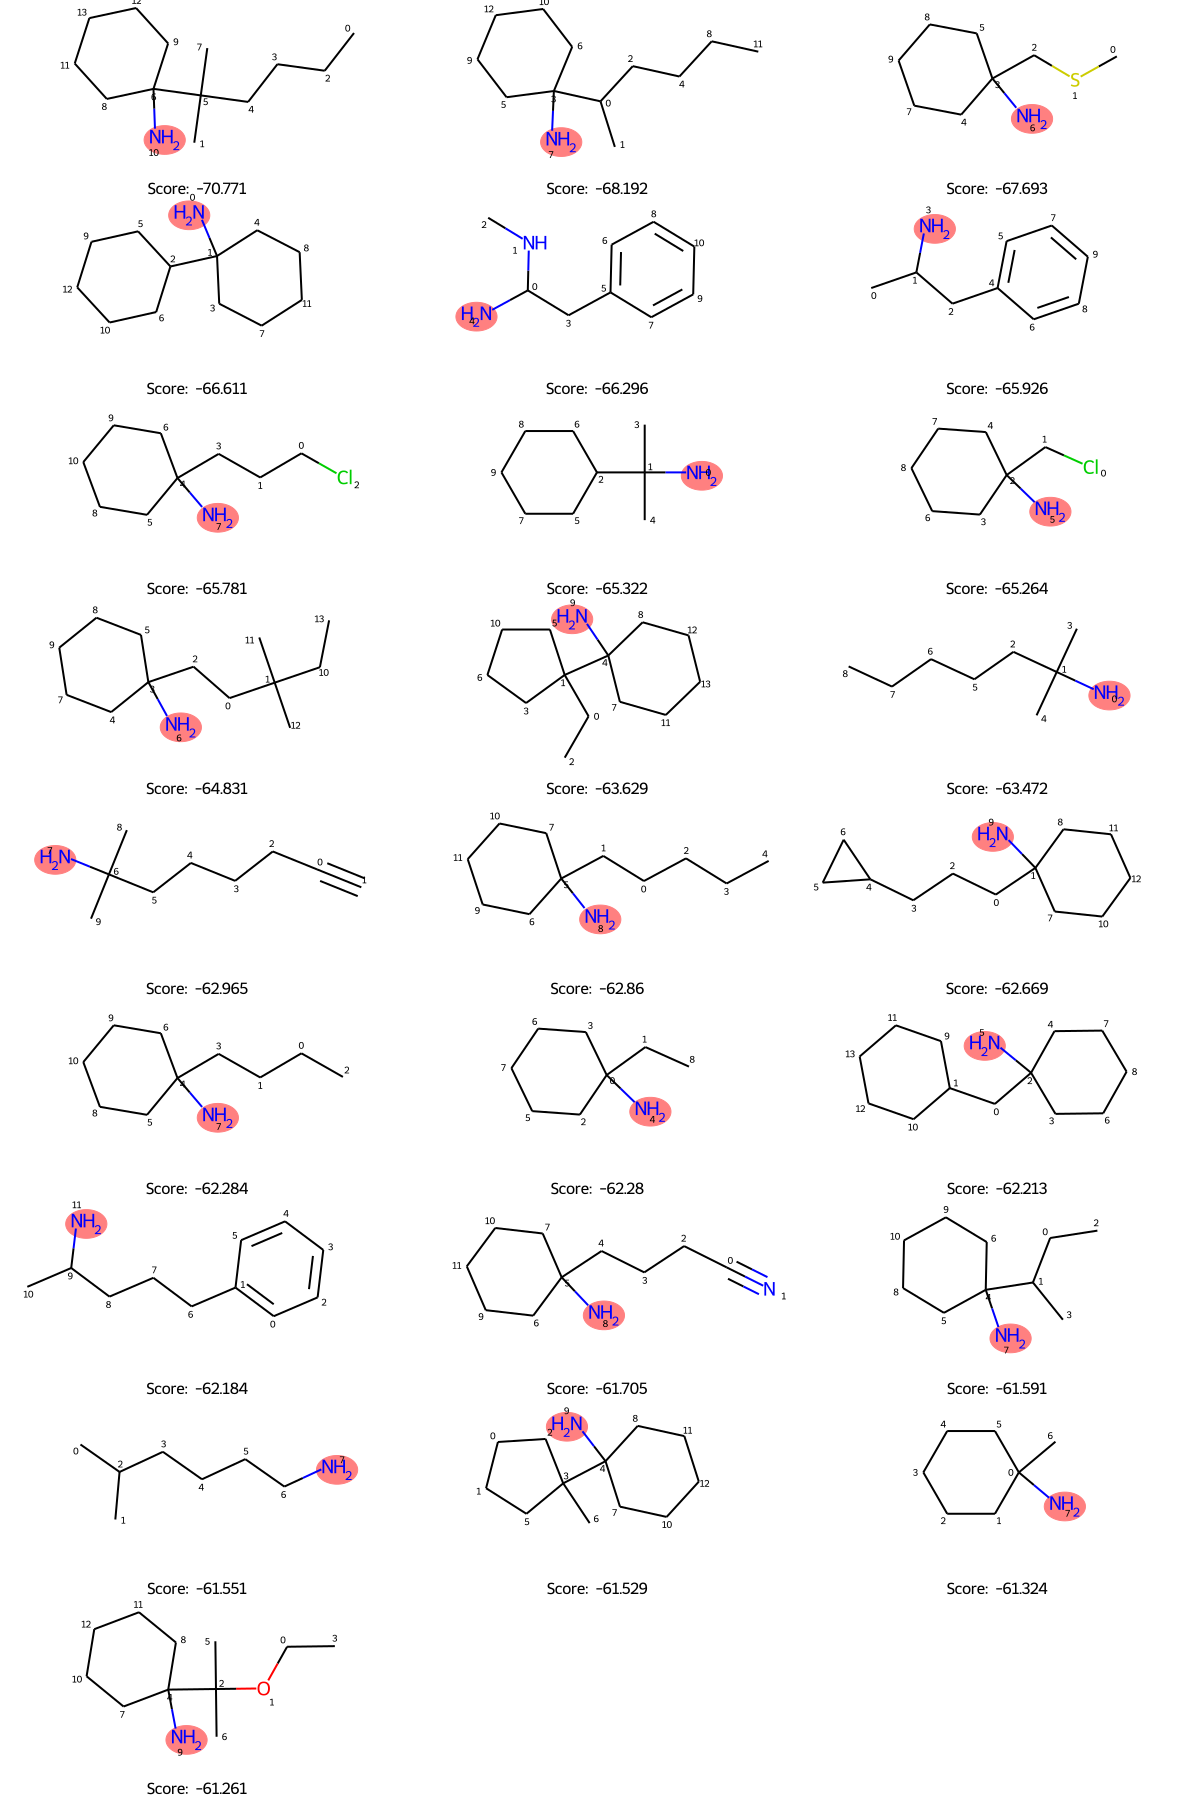

In [13]:
img

In [31]:
with open('mol.svg','w') as f:
    f.write(img.data)

AttributeError: data

In [32]:
im = Draw.MolsToGridImage(mols,molsPerRow=3,maxMols=6,legends=[f'Score:  {round(score,3)}' for x, score in zip(list_idx,score)], subImgSize=(400,200), highlightAtomLists=cut_idx,returnPNG=False)

In [33]:
im.save('image2', format='png')


In [34]:
# For drawing to svg file
#[Chem.Draw.MolToFile(mols[i],f'mol{i}.svg', imageType=lol) for i in range(5)]

In [35]:
pop[0]

((6, 39),
 -80.589,
 ['120\n',
  ' energy: -186.236454353275 gnorm: 0.000577014006 xtb: 6.5.0 (97a52f5)\n',
  'N           -2.13681797599840       -4.39714988700409        3.27028454645932\n',
  'C           -1.29132145247462       -5.57507631406161        3.25116665665729\n',
  'C           -2.16466691742717       -6.79488868299717        3.56678703306832\n',
  'N           -3.54483655269660       -6.48254292771730        3.16222232924622\n',
  'C           -3.73619847973221       -6.66224847367480        1.70634531171162\n',
  'C           -4.31972776029279       -5.35386935238485        1.12720859844166\n',
  'N           -5.01042635424635       -4.73229627836744        2.21955659482249\n',
  'Mo          -4.01102343018836       -4.37119932692296        3.86859627215072\n',
  'N           -3.82775147168839       -5.46467589971476        5.43741118765798\n',
  'C           -4.49638293469094       -6.74278006634056        5.40004793369991\n',
  'C           -4.50749970055476       -7.

In [36]:
interact(conf_viewer_ga,confs=fixed(pop),idx=IntSlider(min=0,max=len(struct)-1,step=1), width=fixed(800), height=fixed(500));
interact(conf_viewer_ga,confs=fixed(pop2),idx=IntSlider(min=0,max=len(struct)-1,step=1), width=fixed(800), height=fixed(500));

interactive(children=(IntSlider(value=0, description='idx', max=49), Output()), _dom_classes=('widget-interact…

interactive(children=(IntSlider(value=0, description='idx', max=49), Output()), _dom_classes=('widget-interact…

In [15]:
img  = Draw.MolsToGridImage(pre_mols,molsPerRow=3,maxMols=9,legends=[f'idx: {idx}' for idx in list_idx], subImgSize=(400,200),returnPNG=False)

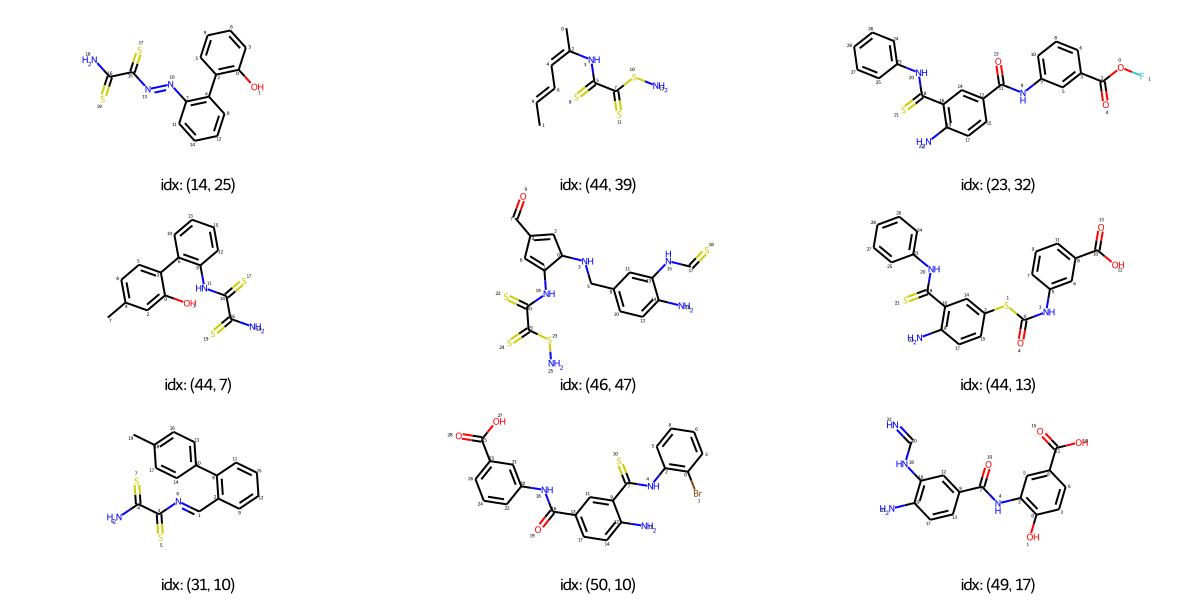

In [16]:
img

In [17]:
img  = Draw.MolsToGridImage(children_mols,molsPerRow=3,maxMols=9,legends=[f'idx: {idx}' for idx in children_idx], subImgSize=(400,200),returnPNG=False, highlightAtomLists=children_cut_idx)

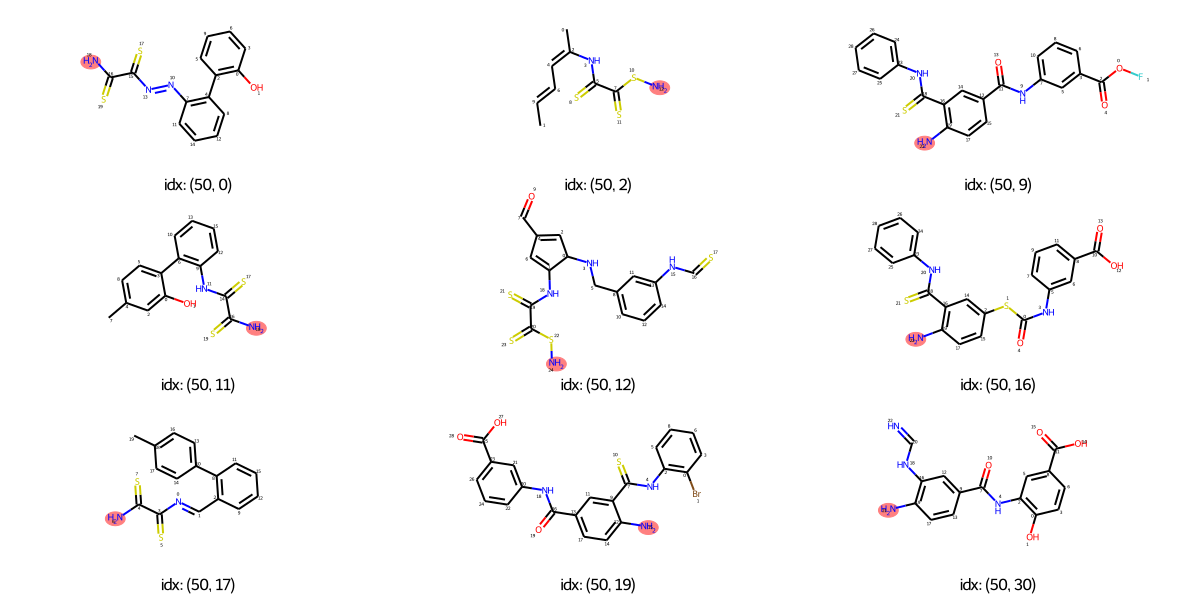

In [18]:
img

### Energy evolution through time

In [17]:
# Get gen paths
gen_objects = sorted(generation_path.rglob('GA[0-9][0-9].pkl'), key=sort_ga)

In [18]:
avg_energy=[]
for elem in gen_objects:
    with open(elem, "rb") as f:
        #f.seek(0)
        gen = pickle.load(f)
        
        df = gen.gen2pd()['score']
        pop_size = len(df)
        
        # Remove the 9999 energies from mean calc
        df = df[df < 1000]
        
        avg_energy.append(df.mean())

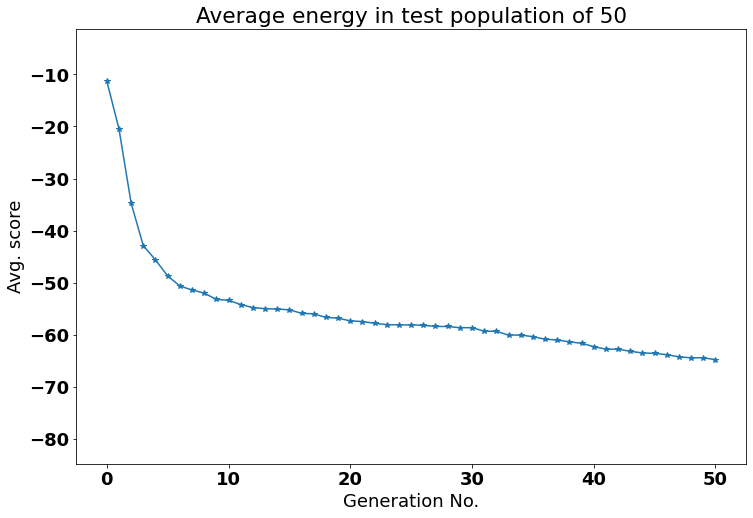

In [19]:
fig, ax = plt.subplots(figsize=(12, 8))
x = np.arange(0,len(avg_energy))
ax.plot(x,avg_energy,'*-')
ax.set(xlabel='Generation No.', ylabel='Avg. score', title=f'Average energy in test population of {pop_size}', ylim =(min(avg_energy)-20,max(avg_energy)+10));
fig.savefig(generation_path/generation_path.stem, dpi=600)

# Compare two structures

In [20]:
# Path to folder with GA.pkl files
generation_path_longrun = Path('~').expanduser()/"generation_data/longrun"
# What GA to look at 
gen_longrun  = 'GA45.pkl'

# Path to folder with GA.pkl files
generation_path_long2 = Path('~').expanduser()/"generation_data/long2"
# What GA to look at 
gen_long2  = 'GA100.pkl'

with open(generation_path_longrun/gen_longrun, "rb") as f:
    gen_longrun = pickle.load(f)
    
with open(generation_path_long2/gen_long2, "rb") as f:
    gen_long2 = pickle.load(f)

ModuleNotFoundError: No module named 'my_utils.my_utils'

In [21]:
path = Path('/home/magstr/generation_data/singlepoint_candidates/results')

In [22]:
candidates = []
for elem in gen_long2.survivors.molecules:
    if elem.idx in [(18,32),(32,70),(64,13)]:
        candidates.append(elem)
for elem in gen_longrun.survivors.molecules:
    if elem.idx in [(44,37),(27,41)]:
        candidates.append(elem)

AttributeError: 'str' object has no attribute 'survivors'

In [29]:
# Create DFT dataframe
d = {'idx': [(18,32), (32,70), (64,13)],'XTB score': [-108.4, -163.52, -86.1], 'DFT': [34.76, 67.1, -36.0]}
df_long2 = pd.DataFrame(data=d)
df_long2

,idx,XTB score,DFT
0,"(18, 32)",-108.40,34.76
1,"(32, 70)",-163.52,67.10
2,"(64, 13)",-86.10,-36.00


In [30]:
# Create DFT dataframe
d = {'idx': [(44,37), (27,41)],'XTB score': [-77.2, -103.1], 'DFT': [-37.1, 11.6]}
df_longrun = pd.DataFrame(data=d)
df_longrun

,idx,XTB score,DFT
0,"(44, 37)",-77.2,-37.1
1,"(27, 41)",-103.1,11.6


In [108]:
df1 = gen_long2.gen2pd().loc[[(18,32),(32,70),(64,13)]]
df2= gen_longrun.gen2pd().loc[[(44,37),(27,41)]]
df_total = pd.concat([df1,df2])
df_total['DFT'] = [34.76, 67.1, -36.0,-37.1, 11.6]
df_total

,,score,energy,sa_score,rdkit_mol,DFT
generation,individual,,,,,
18,32,-108.375581,-108.375581,1.000000,<rdkit.Chem.rdchem.Mol object at 0x7f5b6f79c170>,34.76
32,70,-163.518196,-167.439570,0.976580,<rdkit.Chem.rdchem.Mol object at 0x7f5b6f793170>,67.10
64,13,-86.079413,-86.317547,0.997241,<rdkit.Chem.rdchem.Mol object at 0x7f5b6f79cb70>,-36.00
44,37,-79.229562,-79.229562,1.000000,<rdkit.Chem.rdchem.Mol object at 0x7f5b6d9e3c70>,-37.10
27,41,-103.086978,-108.810688,0.947398,<rdkit.Chem.rdchem.Mol object at 0x7f5b6d9e3230>,11.60


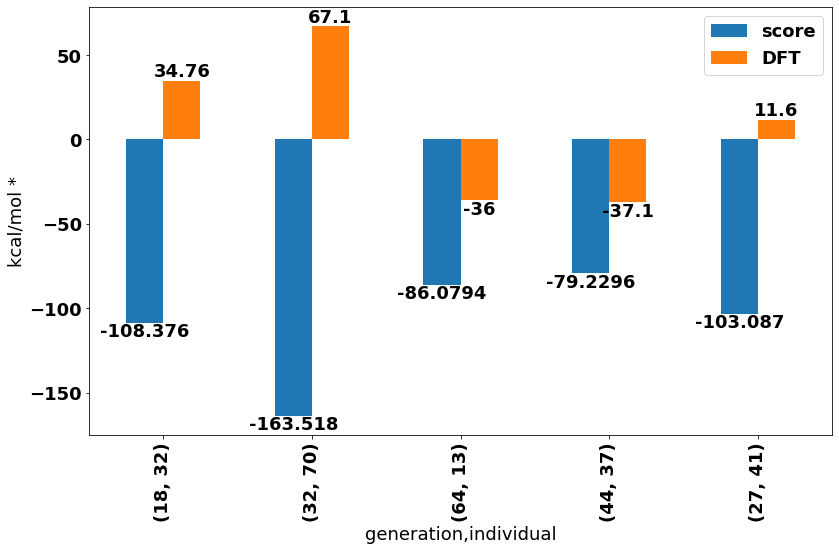

In [109]:
fig, ax = plt.subplots(figsize=(12, 8))
df_total[['score','DFT']].plot.bar(ax=ax);
ax.set(ylabel='kcal/mol *')
for container in ax.containers:
    ax.bar_label(container)
fig.tight_layout()
fig.savefig('singlepoints.png')

In [110]:
# Show the molecules in question:
mols = [x.rdkit_mol for x in candidates]
score = [x.score for x in candidates]
list_idx = [x.idx for x in candidates]
cut_idx = [[x.cut_idx] for x in candidates]

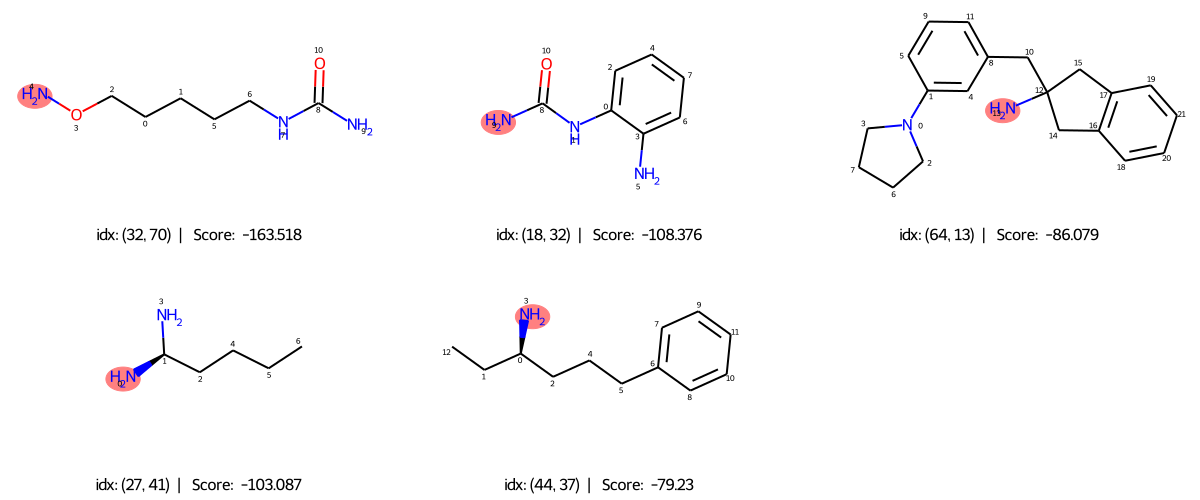

In [111]:
img  = Draw.MolsToGridImage(mols,molsPerRow=3,maxMols=25,legends=[f'idx: {x}  |   Score:  {round(score,3)}' for x, score in zip(list_idx,score)], subImgSize=(400,250), highlightAtomLists=cut_idx,returnPNG=False)
img

In [112]:
# long2
# 018_032
# 032_070
# 064_013

# longrun
# 044_037
# 027_041


In [137]:
# Results folder
res = path/'long2'

folder = '064_013'

# Candidate
candidates_path = sorted(res.rglob(f'{folder}*/*xtbopt.xyz*'))

In [138]:
candidates_path

[PosixPath('/home/magstr/generation_data/singlepoint_candidates/results/long2/064_013_Mo_N2/xtbopt.xyz'),
 PosixPath('/home/magstr/generation_data/singlepoint_candidates/results/long2/064_013_Mo_NH3/xtbopt.xyz')]

In [139]:
#a = read(candidates_path[1])
#view(a, viewer ='ngl')

In [140]:
#v=_
#v.view.add_ball_and_stick("ligand")

In [143]:
draw_generation(str(candidates_path[0]),height=600, width=800)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [144]:
# Folder for camparing structures
draw_generation(str(candidates_path[1]),height=600, width=600)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [119]:
# ~/Documents/nitrogenase/schrock/diagrams_schrock/gfn2

# High score mol (-200)

In [120]:
#-202.327 to -85.5257 after SA

In [40]:
p1='/home/magstr/generation_data/longrun/036_025_Mo_N2/conf000/xtbopt.xyz'
p2='/home/magstr/Documents/GB_GA/templates/core_withHS.xyz'

In [41]:
draw_generation(p1, height=400, width=600)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [42]:
draw_generation(p2,height=400, width=600)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

### Draw_generation debugging
